# Load data

In [1]:
# Libraries required 
import sqlite3
import pandas as pd
import numpy as np

In [2]:
# Read sqlite query results into a pandas DataFrame
sql_conn = sqlite3.connect("sqlite.db")
exec_df = pd.read_sql_query("SELECT * from exec", sql_conn)
sql_conn.close()
exec_df.head()

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [3]:
exec_df.count()

ts        2503
exe       2503
pid       2503
ppid      2503
path      2503
docker     787
depth     2503
rates     2503
dtype: int64

We need to split the json in rate column into two seperate columns, 'rate1s' and 'rate5s'.
    1. Use rates column to create a dataframe of 2 columns 'rate1s', 'rate5s'.
    2. Concat the dataframe from step 1 with exec_df to get the final clean dtaframe.

In [4]:
# Split rates column into two columns
rates_df = exec_df['rates'].apply(lambda x : dict(eval(x)) ).apply(pd.Series)
rates_df.columns = ['rate1s', 'rate5s']
# Concat this with exec_df to get the entire dataset
exec_df_clean = pd.concat([exec_df, rates_df], axis=1)
exec_df_clean.head()

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}",1.0,0.2
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}",2.0,0.4
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}",3.0,0.6
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}",1.0,0.8
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}",2.0,1.0


In [5]:
# Read sqlite query results into a pandas DataFrame
sql_conn = sqlite3.connect("sqlite.db")
tcp_df = pd.read_sql_query("SELECT * from tcplife", sql_conn)
sql_conn.close()
tcp_df.head()

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality
0,25.147065,28668,60290,80,30,0,93.65,"[[0, 0, 1, 0, 0], 93.65, 93.65]","[[0, 0, 1, 0, 0], 30, 30]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.362980,1
1,25.536215,28669,47054,80,166,0,192.11,"[[1, 0, 0, 0, 1], 93.65, 192.11]","[[1, 0, 0, 0, 1], 30, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-14.629130,1
2,26.039532,28673,53762,80,0,0,81.72,"[[2, 0, 0, 0, 1], 81.72, 192.11]","[[2, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.452350,1
3,26.201396,28673,50248,80,0,0,25.16,"[[1, 1, 1, 0, 1], 25.16, 192.11]","[[3, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.414340,1
4,26.329412,28673,57968,443,0,0,17.78,"[[2, 1, 1, 0, 1], 17.78, 192.11]","[[4, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-23.817379,0


In [6]:
tcp_df.count()

ts             944
pid            944
lport          944
rport          944
rx             944
tx             944
dur            944
histotimes     944
histosizes     944
histoports     944
docker         944
prediction     944
predquality    944
dtype: int64

# Data Visualization
    To plot the data, the type of chart chosen was scatterplot, because
    
        1. There were few unique values among the columns for which a plot was drawn, using a scatter plot makes it
            easier to see the unique values without the clutter of say a line chart.
            
        2. Outliers (in the visual sense) are easy to spot.

In [7]:
# Libraries required for visualization
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [8]:
def display_plot_hist(input_df, x, y, x_lim=0, y_lim=0):
    """
    Function to display a scatter plot and histogram given a dataframe and the corresponding X and Y axis
    
    @Param:
        input_df: the input dataframe
        x: the name of the column to be considered the x axis
        y: the name of the column to be considered the y axis
           , also the column for which we produce a histogram
        x_lim: the x axis limits, pass as list (optional)
        y_lim: the y axis limit, pass as list (optional)
    
    @Return:
        None
    """
    # Display Scatter plot
    print('------------------------------------------------'+str(y).upper()+'-----------------------------------------------')
    plt.figure()
    sns.lmplot(x, y, data=input_df, fit_reg=False, size=4, aspect=4)
    if x_lim != 0:
        plt.xlim(x_lim)  
        plt.ylim(y_lim) 
    # Histogram
    plt.figure()
    sns.distplot(input_df[y], kde=True, rug=True)

## Plot 'exec' table

------------------------------------------------DEPTH-----------------------------------------------


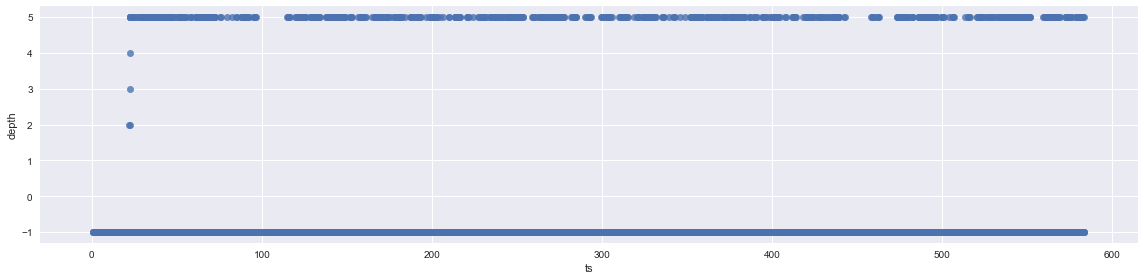

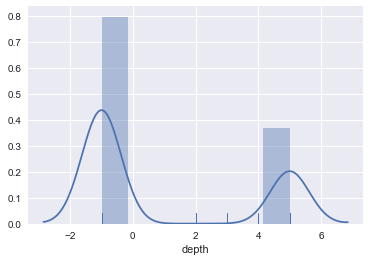

In [9]:
display_plot_hist(input_df=exec_df_clean, x='ts', y='depth')

------------------------------------------------RATE1S-----------------------------------------------


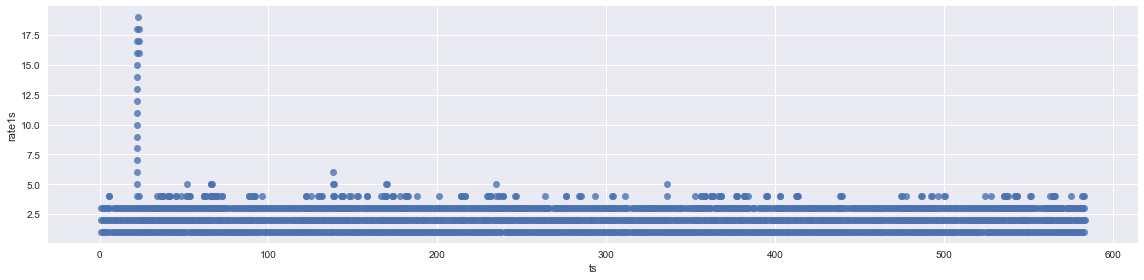

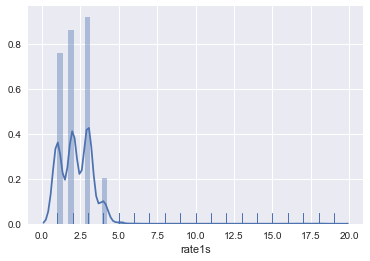

In [10]:
display_plot_hist(input_df=exec_df_clean, x='ts', y='rate1s')

------------------------------------------------RATE5S-----------------------------------------------


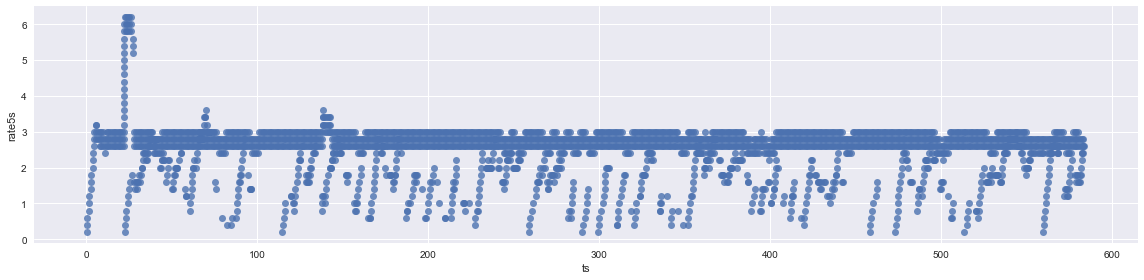

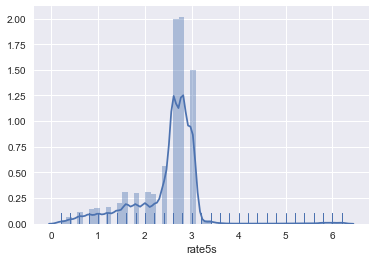

In [11]:
display_plot_hist(input_df=exec_df_clean, x='ts', y='rate5s')

## Observation:
    1. We can see some outliers, among the plotted data.
    2. Are these outliers part of the real data ?
        Most outliers lie near 22 ts ? Is there any significance to this time
    3. Exploring the data, leads to a discovery that the field 'docker' is NaN when either 'depth', 'rate1s', 'rate5s' are outliers.

In [12]:
exec_df_clean[(exec_df_clean['depth'] == 4) | (exec_df_clean['depth'] == 3) | (exec_df_clean['depth'] == 2)]

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
67,22.069,auplink,28606,917,/sbin/auplink,None,2,"{""1"": 5.0, ""5"": 3.4}",5.0,3.4
68,22.107,auplink,28607,917,auplink,None,2,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
77,22.221,docker-containe,28628,1051,/usr/bin/docker-containerd-shim,None,3,"{""1"": 15.0, ""5"": 5.4}",15.0,5.4
78,22.228,docker-runc,28633,28628,/usr/bin/docker-runc,None,4,"{""1"": 16.0, ""5"": 5.6}",16.0,5.6


In [13]:
exec_df_clean['depth'].value_counts()

-1    1709
 5     790
 2       2
 3       1
 4       1
Name: depth, dtype: int64

In [14]:
exec_df_clean[exec_df_clean.depth != 5]['docker'].value_counts()

Series([], Name: docker, dtype: int64)

From the above command, we see that when ever the value of 'depth' is not 5 docker is empty.

Need more information about the data to make statements about this occurrence.

We can see similar behaviour for 'rate1s' and 'rate5s'

In [15]:
exec_df_clean['rate1s'].value_counts()

3.0     830
2.0     775
1.0     686
4.0     183
5.0      11
17.0      2
16.0      2
6.0       2
18.0      2
8.0       1
7.0       1
19.0      1
9.0       1
11.0      1
12.0      1
13.0      1
14.0      1
15.0      1
10.0      1
Name: rate1s, dtype: int64

In [16]:
exec_df_clean[exec_df_clean.rate1s > 5]['docker'].value_counts()

Series([], Name: docker, dtype: int64)

In [17]:
exec_df_clean[(exec_df_clean['rate1s'] > 5)]

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
68,22.107,auplink,28607,917,auplink,None,2,"{""1"": 6.0, ""5"": 3.6}",6.0,3.6
69,22.155,grep,28618,28615,/bin/grep,None,-1,"{""1"": 7.0, ""5"": 3.8}",7.0,3.8
70,22.159,ifquery,28621,-1,/sbin/ifquery,None,-1,"{""1"": 8.0, ""5"": 4.0}",8.0,4.0
71,22.159,ifquery,28617,28615,/sbin/ifquery,None,-1,"{""1"": 9.0, ""5"": 4.2}",9.0,4.2
72,22.164,ifquery,28622,-1,/sbin/ifquery,None,-1,"{""1"": 10.0, ""5"": 4.4}",10.0,4.4
73,22.187,grep,28620,-1,grep,None,-1,"{""1"": 11.0, ""5"": 4.6}",11.0,4.6
74,22.187,systemd-sysctl,28623,28613,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 12.0, ""5"": 4.8}",12.0,4.8
75,22.188,ifquery,28619,-1,/sbin/ifquery,None,-1,"{""1"": 13.0, ""5"": 5.0}",13.0,5.0
76,22.199,systemd-sysctl,28624,28614,/lib/systemd/systemd-sysctl,None,-1,"{""1"": 14.0, ""5"": 5.2}",14.0,5.2
77,22.221,docker-containe,28628,1051,/usr/bin/docker-containerd-shim,None,3,"{""1"": 15.0, ""5"": 5.4}",15.0,5.4


In [18]:
exec_df_clean['rate5s'].value_counts()

2.8    606
2.6    598
3.0    451
2.4    170
2.0     93
1.6     92
1.8     89
2.2     86
1.4     60
1.2     50
1.0     47
0.8     44
0.6     35
0.4     20
3.2     11
0.2     10
3.4     10
6.2      5
5.8      5
6.0      5
3.6      3
5.2      2
5.4      2
5.6      2
4.2      1
4.6      1
4.4      1
3.8      1
5.0      1
4.0      1
4.8      1
Name: rate5s, dtype: int64

In [19]:
exec_df_clean[exec_df_clean.rate5s > 3.6]['docker'].value_counts()

Series([], Name: docker, dtype: int64)

## Plotting data without values which have docker as None

------------------------------------------------DEPTH-----------------------------------------------


/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


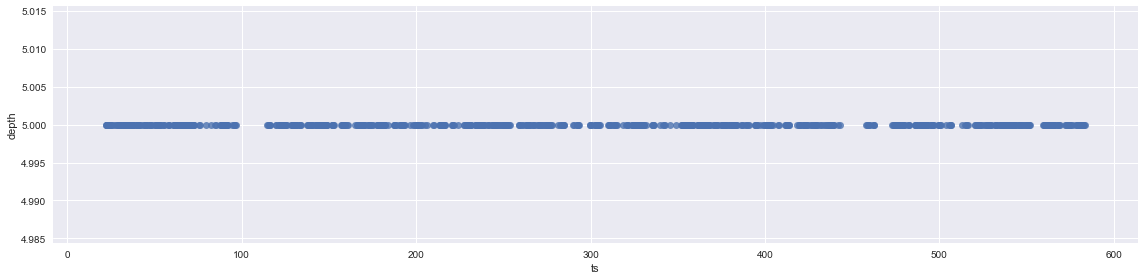

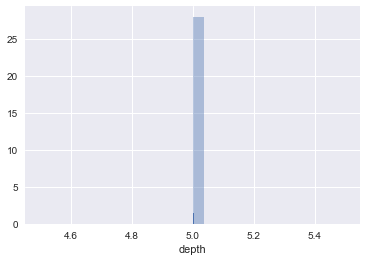

In [20]:
display_plot_hist(input_df=exec_df_clean[exec_df_clean.depth == 5], x='ts', y='depth')

------------------------------------------------RATE1S-----------------------------------------------


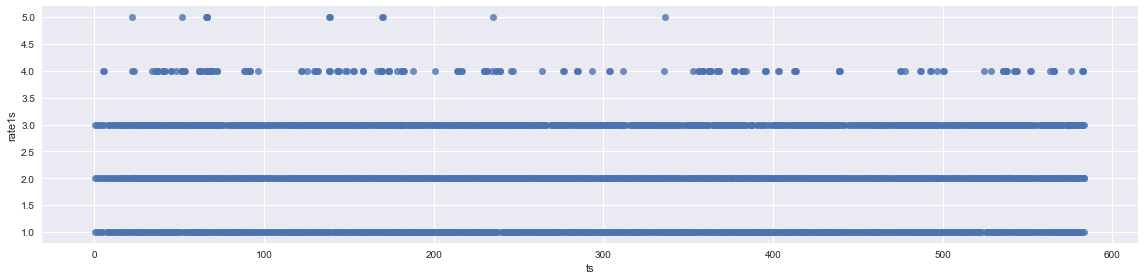

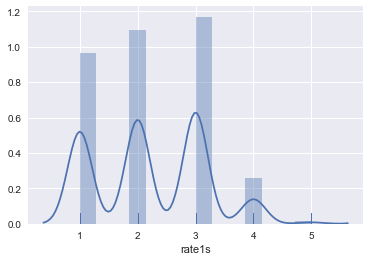

In [21]:
display_plot_hist(input_df=exec_df_clean[exec_df_clean.rate1s <= 5], x='ts', y='rate1s')


------------------------------------------------RATE5S-----------------------------------------------


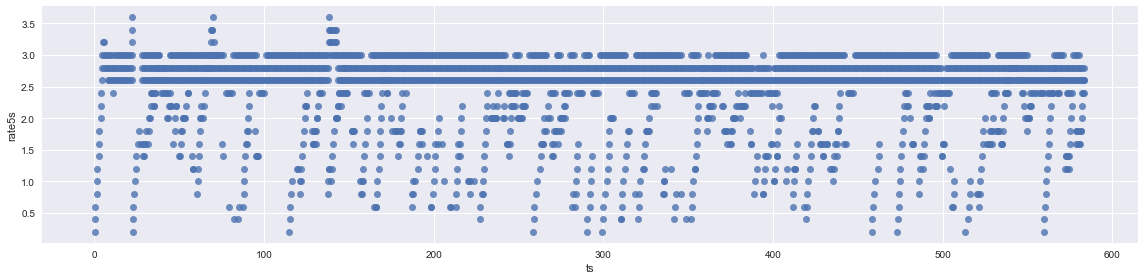

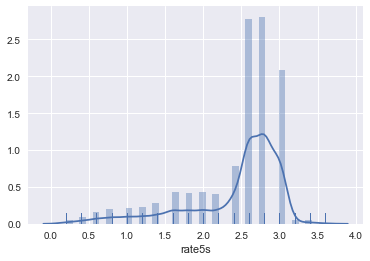

In [22]:
display_plot_hist(input_df=exec_df_clean[exec_df_clean.rate5s <= 3.6], x='ts', y='rate5s')

------------------------------------------------TS-----------------------------------------------


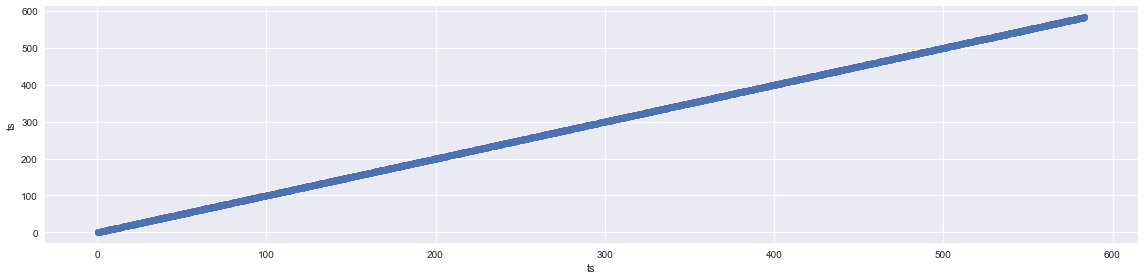

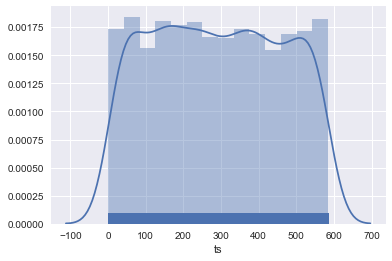

In [23]:
display_plot_hist(input_df=exec_df_clean, x='ts', y='ts')

## Plot 'tcp' table

------------------------------------------------RX-----------------------------------------------


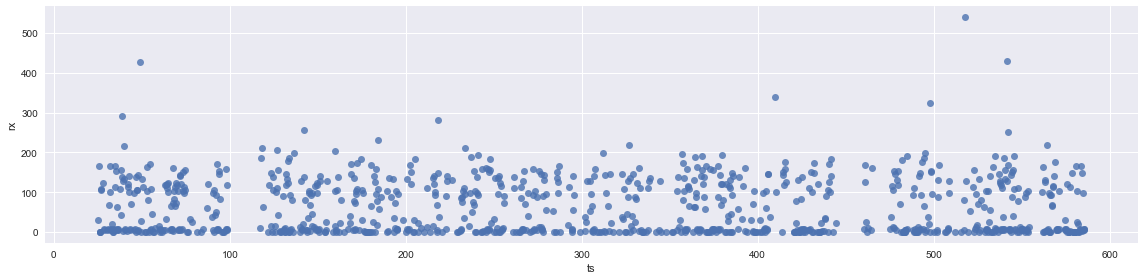

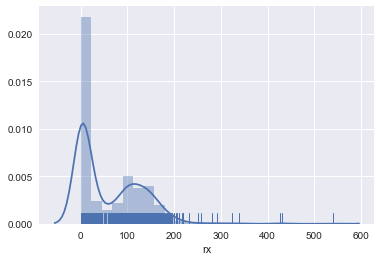

In [24]:
display_plot_hist(input_df=tcp_df, x='ts', y='rx')

------------------------------------------------TX-----------------------------------------------


/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


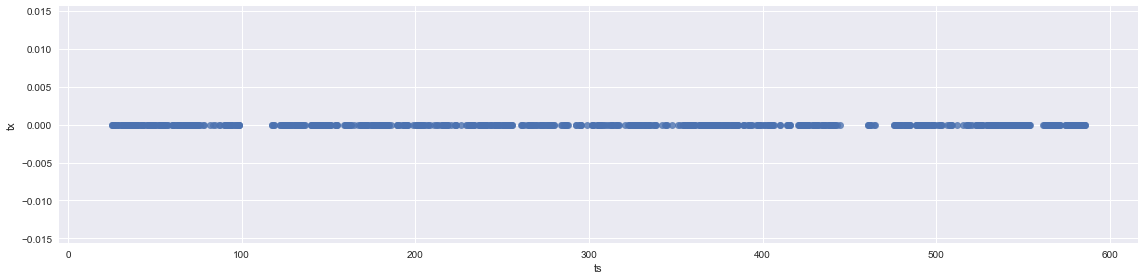

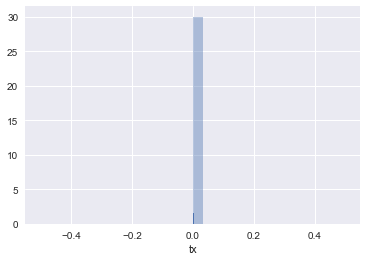

In [25]:
display_plot_hist(input_df=tcp_df, x='ts', y='tx')

------------------------------------------------DUR-----------------------------------------------


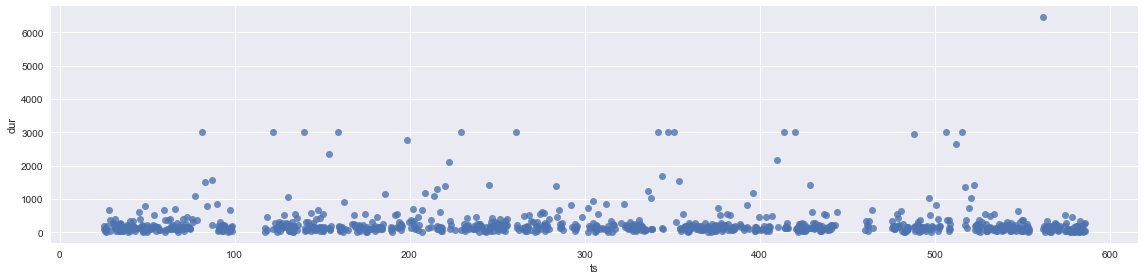

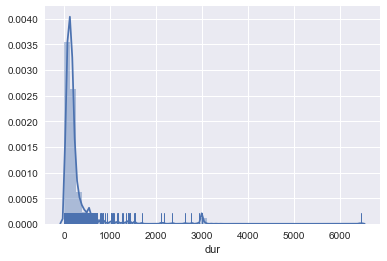

In [26]:
display_plot_hist(input_df=tcp_df, x='ts', y='dur')

In [27]:
# convert objects to int for plotting 
tcp_df[['lport', 'rport']] = tcp_df[['lport', 'rport']].astype(int)

------------------------------------------------RPORT-----------------------------------------------


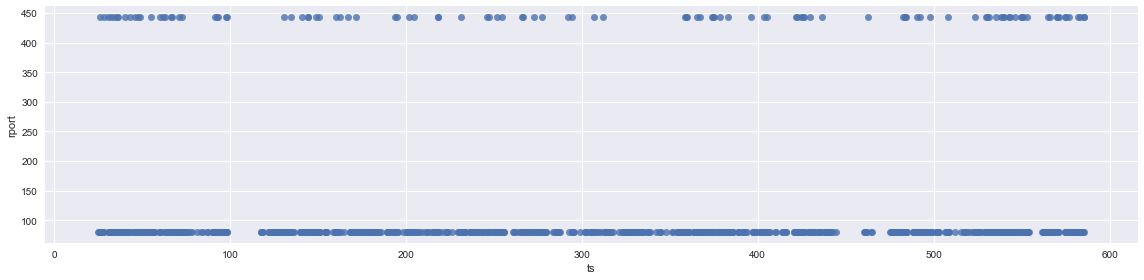

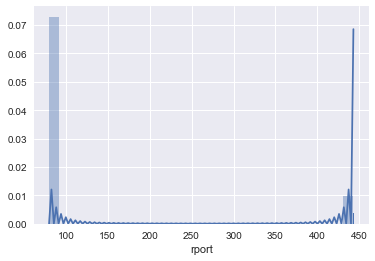

In [28]:
display_plot_hist(input_df=tcp_df, x='ts', y='rport')

In [29]:
tcp_df['rport'].value_counts()

80     833
443    111
Name: rport, dtype: int64

------------------------------------------------LPORT-----------------------------------------------


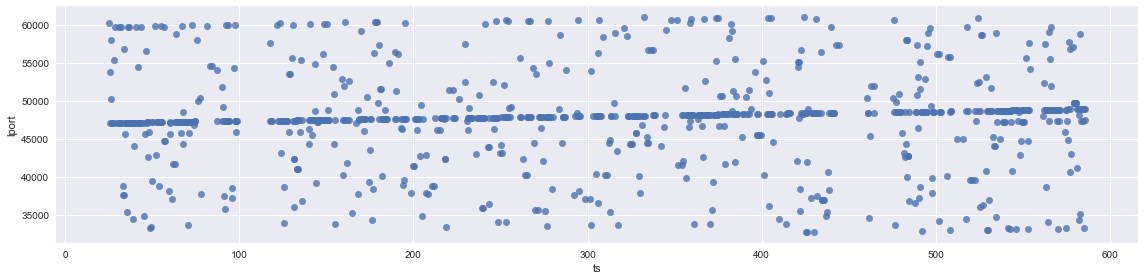

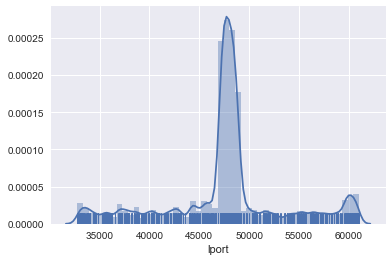

In [30]:
display_plot_hist(input_df=tcp_df, x='ts', y='lport')

## Observation: 
    No empty docker, hence no obvious way to visually find outliers.

# Data Statistic:

In [31]:
from scipy.stats.mstats import mode
def get_descriptive_stats(input_df, column):
    """
    Function to print the descriptive statics of a give dataframe
    
    @Params:
        input_df: the input data frame which contains a column whose descriptive statics is to be calculated
        column: the name of the column whose descriptive statics is to be calculated.
        
    @Returns:
        desc_stat: a dictionary with the descriptive statistics
    """
    KEY_ORDER = ['count', 'min', 'max', 'mean', 'median','mode', 'std', 'variance', '25%', '50%', '75%', 'NaN_perc']
    desc_stat = {}
    desc_stat = input_df[column].describe().to_dict()
    desc_stat['variance'] = input_df[column].var()
    desc_stat['median'] = input_df[column].median()
    desc_stat['mode'] = mode(input_df[column])[0][0]
    desc_stat['NaN_perc'] = str(input_df[column].isnull().sum() / desc_stat['count']) + '%'
    print('---------------------DESCRIPTIVE STATICS---------------------')
    for key in KEY_ORDER:
        print(key +': '+str(desc_stat[key]) )
    print('-------------------------------------------------------------')
    return desc_stat

In [32]:
desc_stat = get_descriptive_stats(tcp_df, 'dur')

---------------------DESCRIPTIVE STATICS---------------------
count: 944.0
min: 5.04
max: 6454.02
mean: 261.219120763
median: 144.64999999999998
mode: 50.92
std: 479.331879478
variance: 229759.05068374358
25%: 85.5125
50%: 144.65
75%: 226.7975
NaN_perc: 0.0%
-------------------------------------------------------------


# Anomalous dur 
    Modified Z-score method to detect outliers.
    reference:
         1. https://colingorrie.github.io/outlier-detection.html
         2. http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
         3. http://www.itl.nist.gov/div898/handbook/eda/section3/eda356.htm#MAD
    
    The modified Z score uses median instead of mean. 
    
    Reason for choosing modified Z score over Z score:
        1. Median is more stable than mean which is heavily affected by outliers.
        2. It is a good measure of dispersion.
        
        

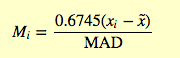

In [33]:
from IPython.display import Image
import pylab
Image(filename='/Users/Kevin/Documents/jobApplication/timeSeriesPrediction/Cap8_DS_Challenge_V1/mod_z_score.png')

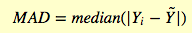

In [34]:
Image(filename='/Users/Kevin/Documents/jobApplication/timeSeriesPrediction/Cap8_DS_Challenge_V1/MAD.png')

In [35]:
def outlier_det(data, col_to_check, time_col, th=3.5):
    data_outlier_det = data
    data_outlier_det['median'] = data_outlier_det[col_to_check].median()
    data_outlier_det['mean_abs_deviation'] = data_outlier_det[col_to_check].mad()
    data_outlier_det['modified_z_scores'] = 0.6745 * (data_outlier_det[col_to_check] - data_outlier_det['median']) / data_outlier_det['mean_abs_deviation']
    data_outlier_det['mad_anomalies'] = 0
    data_outlier_det['mad_anomalies'] = [1 if abs(x) > th else 0 for x in data_outlier_det['modified_z_scores']]
    data_outlier_det['mad_anomalies'].value_counts()
    ts_anomaly = data_outlier_det[data_outlier_det.mad_anomalies == 1][time_col]
    dur_anomaly = data_outlier_det[data_outlier_det.mad_anomalies == 1][col_to_check]
    plt.figure(figsize=(15, 8))
    plt.plot(data_outlier_det[time_col], data_outlier_det[col_to_check], "k.")
    plt.plot(data_outlier_det[time_col], data_outlier_det['median'], color='green')
    plt.xlabel(time_col)
    plt.ylabel(col_to_check)
    plt.plot(ts_anomaly, dur_anomaly, "r*", markersize=12)
    pylab.legend(loc='upper left')
    return data_outlier_det

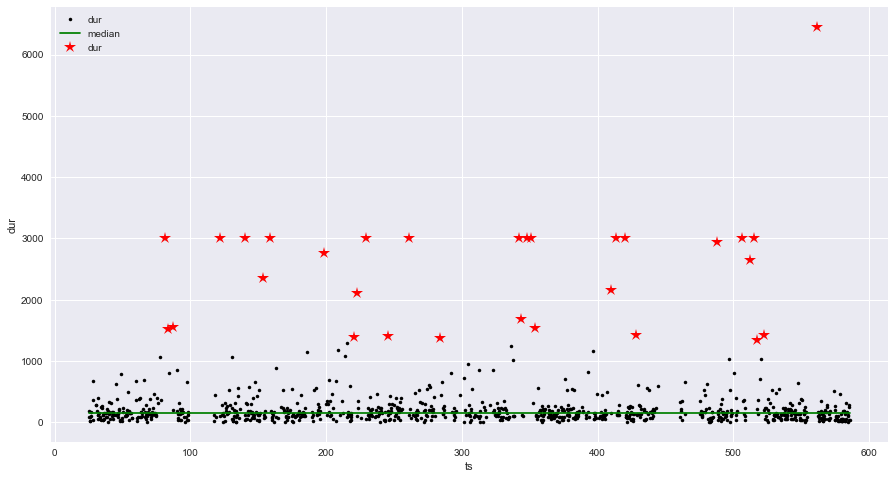

In [36]:
data_outlier_det = outlier_det(data = tcp_df, col_to_check = 'dur', time_col= 'ts')

## Modified Z score with rolling window

In [37]:
def outlier_det_rolling_window(data, col_to_check, time_col, th=3.5, win_size = 20 ):
    mad = lambda x: np.fabs(x - x.mean()).mean()
    data_outlier_det = data
    data_outlier_det['rolling_median'] =data_outlier_det.rolling(window=win_size, on=time_col).median()[col_to_check]
    data_outlier_det['rolling_mad'] = data_outlier_det.rolling(window=win_size, on=time_col).apply(mad)[col_to_check]
    data_outlier_det['rolling_modified_z_scores'] = 0.6745 * (data_outlier_det[col_to_check] - data_outlier_det['rolling_median']) / data_outlier_det['rolling_mad']
    data_outlier_det['rolling_mad_anomalies'] = [1 if abs(x) > th else 0 for x in data_outlier_det['rolling_modified_z_scores']]
    ts_r_anomaly = data_outlier_det[data_outlier_det.rolling_mad_anomalies == 1][time_col]
    dur_r_anomaly = data_outlier_det[data_outlier_det.rolling_mad_anomalies == 1][col_to_check]
    data_outlier_det[data_outlier_det.rolling_modified_z_scores > 2]['rolling_modified_z_scores']
    plt.figure(figsize=(15, 8))
    plt.plot(data_outlier_det[time_col], data_outlier_det[col_to_check], "k.")
    plt.plot(data_outlier_det[time_col], data_outlier_det['rolling_median'], color='green')
    plt.plot(ts_r_anomaly, dur_r_anomaly, "r*", markersize=12)
    pylab.legend(loc='upper left')
    return data_outlier_det

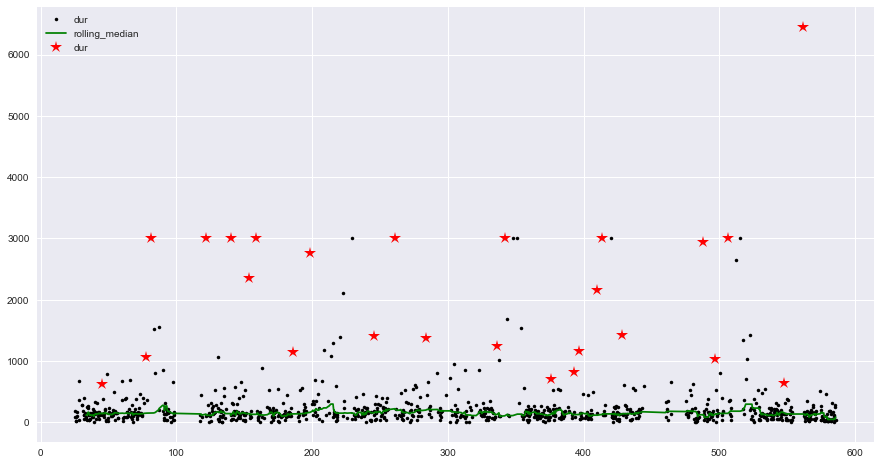

In [38]:
data_outlier_det_rw = outlier_det_rolling_window(data = tcp_df, col_to_check = 'dur', time_col= 'ts')

## Observation:
    1. Rolling window method seems to be more sensitive to some trends.
    2. The bigger the window the more simliar the rolling window method is to the standard MAD method.
    3. Deciding the window size requires more information about the data.

# Data Modeling:
    Approach
        1. Remove outliers
        2. Check for stationarity (ADF)
        3. ACF, PACF plots to check for type of time series data
        4. Take out last 25 data points for validation
        5. Build ARIMA model, use gridsearch
        6. Validate with data from step 4
    
    Assumption:
        1. The data are collected at regular interval to get to a univariate model

In [47]:
# 1. remove outliers
clean_tcp_df = data_outlier_det[data_outlier_det.mad_anomalies != 1]

In [40]:
# 2. Check for stationarity, using Augmented Dickey Fuller test
from pandas import Series
from statsmodels.tsa.stattools import adfuller
result = adfuller(clean_tcp_df['dur'], autolag='AIC', regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -27.962677
p-value: 0.000000
Critical Values:
	5%: -2.865
	10%: -2.568
	1%: -3.438


The p-value is lower than 1%, we can reject the null hypothesis(the time series is stationary) with a significance level of 1% (really low probability that this is a statistical fluke)

(-0.2, 0.2)

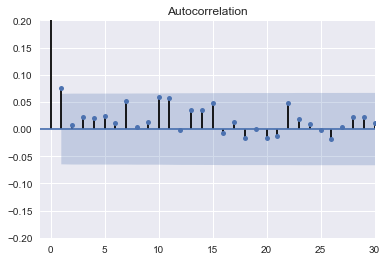

In [41]:
# 3. ACF, PACF plots to check for types of time series data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(clean_tcp_df['dur'])
plt.xlim(-1, 30)  
plt.ylim(-0.2, 0.2) 

(-0.2, 0.2)

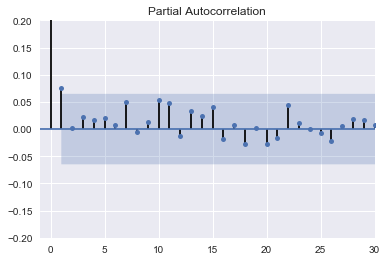

In [42]:
plot_pacf(clean_tcp_df['dur'])
plt.xlim(-1, 30)  
plt.ylim(-0.2, 0.2) 

From the above plots lets assume p, d, q to be 1, 0, 1

In [43]:
# 4. Take out last 25 data points for validation
tcp_val_df  = clean_tcp_df[889:]
clean_tcp_df = clean_tcp_df[:889]

In [46]:
# 5. ARIMA model build
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

# data is a series of data points, params tuple of (p, d, q) for the ARIMA model. 
def evaluate_arima_model(data, params):
    data = data.astype('float32')   
    # train / test split, 70/30
    # since this is a time series and we are forecasting the data
    # we have to split the data sequentially
    train_size = int(len(data) * 0.70)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    predictions = []
    
    # MODEL BUILDING PROCESS
    # 1. build model on train data
    # 2. forecast the next data point in time
    # 3. Add this prediction to the predictions list
    # 4. Add the real value of the next data point in time to the train set
    # 5. repeat process 1-4 until no data points left
    # 6. calculate RMSE
    # 7. get AIC, BIC of the final model 
    # 8. return the evaluation metics along with the params as 'ARIMA(p, d, q)' as the key
    
    for i in range(len(test)):
        arima_model = ARIMA(history, order = params)
        arima_model_fit = arima_model.fit(disp=0)
        y_forecast = arima_model_fit.forecast()[0]
        predictions.append(y_forecast)
        history.append(test.iloc[i])
    mse =  mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    output_dict = {}
    arma_results = ARMAResults.summary(arima_model_fit)
    output_dict = {'RMSE':rmse, 'ARIMA_MODEL': arima_model_fit, 'PARAMS': params}
    return output_dict

In [65]:
# Assign ranges for p, d, q
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)

In [66]:
# Grid search
warnings.filterwarnings("ignore")
out_list = []
best_score, best_cfg, aic, bic = float("inf"), None, None, None
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                arima_result = evaluate_arima_model(clean_tcp_df['dur'], (p, d, q))
                out_list.append(arima_result)
                if arima_result['RMSE'] < best_score:
                    best_score, best_cfg, aic, bic = arima_result['RMSE'], arima_result['PARAMS'], arima_result['ARIMA_MODEL'].aic, arima_result['ARIMA_MODEL'].bic
                print('PARAMS: {}, RMSE: {}, AIC: {}, BIC: {}'.format(arima_result['PARAMS'], arima_result['RMSE'], arima_result['ARIMA_MODEL'].aic, arima_result['ARIMA_MODEL'].bic))
            except:
                continue

PARAMS: (0, 0, 1), RMSE: 156.4928820361095, AIC: 11779.517097389713, BIC: 11793.88401261869
PARAMS: (0, 1, 1), RMSE: 157.51465597405485, AIC: 11776.779639239669, BIC: 11791.143174186598
PARAMS: (1, 0, 0), RMSE: 156.50682208808252, AIC: 11779.553580286425, BIC: 11793.920495515402
PARAMS: (1, 0, 1), RMSE: 156.78925872058517, AIC: 11781.507742838607, BIC: 11800.663629810575
PARAMS: (1, 1, 0), RMSE: 188.7770043529606, AIC: 12108.635636049701, BIC: 12122.99917099663
PARAMS: (1, 1, 1), RMSE: 156.34929915150764, AIC: 11774.477405678937, BIC: 11793.628785608176


In [48]:
# Validate - forecast the next 25 values
# get the best model
best_arima_model = evaluate_arima_model(clean_tcp_df['dur'], (1, 1, 1)) 

/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Kevin/anaconda/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n

In [49]:
forecast_25 = best_arima_model['ARIMA_MODEL'].forecast(steps = 25)[0]
# RMSE
mse =  mean_squared_error(tcp_val_df['dur'], forecast_25)
rmse = sqrt(mse)
print('RMSE: {}'.format(rmse))

RMSE: 113.49557559991543


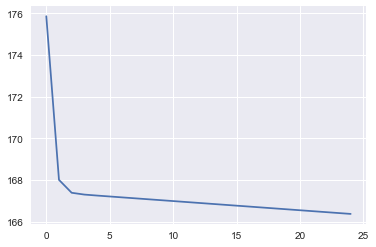

In [50]:
plt.plot(forecast_25)

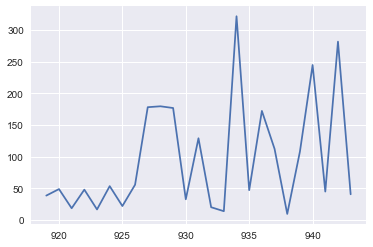

In [51]:
plt.plot(tcp_val_df['dur'])

# Repeat this pipeline for lports

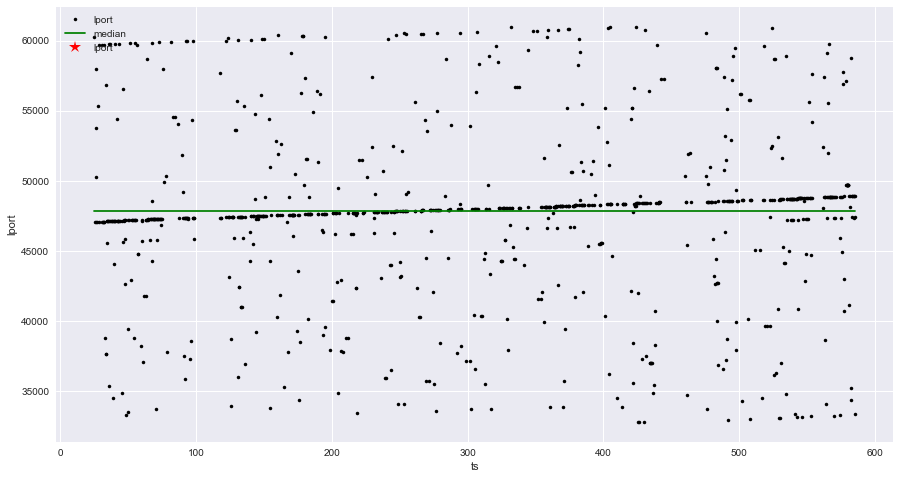

In [76]:
# 1. clean outliers 
# get outliers
data_lport_outlier_det = outlier_det(data = tcp_df, col_to_check = 'lport', time_col= 'ts')
clean_tcp_df = data_lport_outlier_det[data_lport_outlier_det.mad_anomalies != 1]

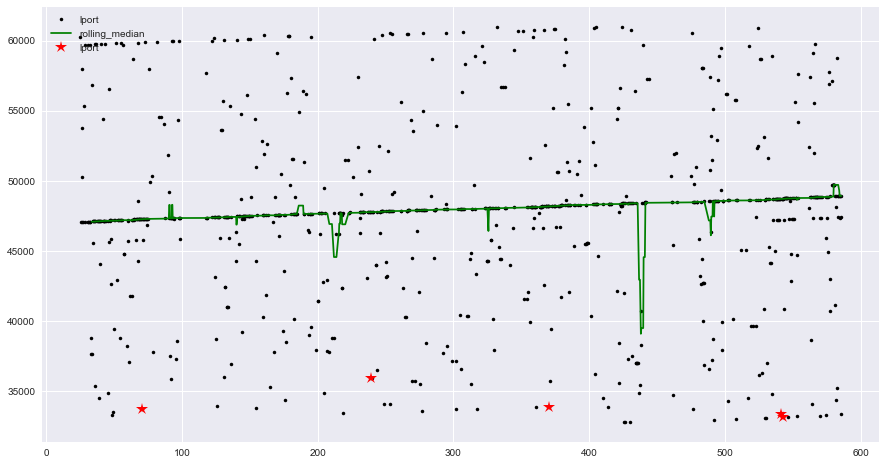

In [91]:
clean_tcp_df = outlier_det_rolling_window(data = tcp_df, col_to_check = 'lport', time_col= 'ts')

In [92]:
# 2. Check for stationarity, using Augmented Dickey Fuller test
from pandas import Series
from statsmodels.tsa.stattools import adfuller
result = adfuller(clean_tcp_df['lport'], autolag='AIC', regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.365201
p-value: 0.000000
Critical Values:
	5%: -2.865
	10%: -2.568
	1%: -3.437


(-0.2, 0.2)

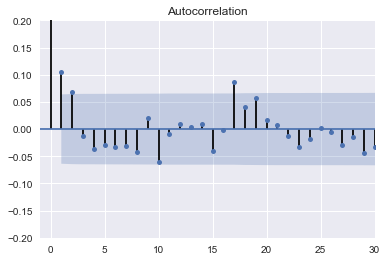

In [93]:
# 3. ACF, PACF plots to check for types of time series data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(clean_tcp_df['lport'])
plt.xlim(-1, 30)  
plt.ylim(-0.2, 0.2) 

(-0.2, 0.2)

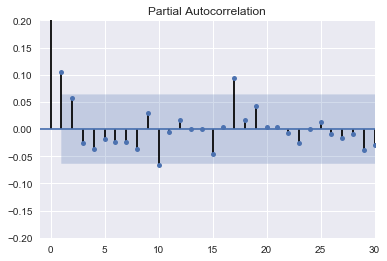

In [94]:
plot_pacf(clean_tcp_df['lport'])
plt.xlim(-1, 30)  
plt.ylim(-0.2, 0.2) 

In [96]:
# 4. Take out last 25 data points for validation
tcp_val_df  = clean_tcp_df[919:]
clean_tcp_df = clean_tcp_df[:919]

In [97]:
# Grid search
warnings.filterwarnings("ignore")
out_list = []
best_score, best_cfg, aic, bic = float("inf"), None, None, None
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                arima_result = evaluate_arima_model(clean_tcp_df['lport'], (p, d, q))
                out_list.append(arima_result)
                if arima_result['RMSE'] < best_score:
                    best_score, best_cfg, aic, bic = arima_result['RMSE'], arima_result['PARAMS'], arima_result['ARIMA_MODEL'].aic, arima_result['ARIMA_MODEL'].bic
                print('PARAMS: {}, RMSE: {}, AIC: {}, BIC: {}'.format(arima_result['PARAMS'], arima_result['RMSE'], arima_result['ARIMA_MODEL'].aic, arima_result['ARIMA_MODEL'].bic))
            except:
                continue

PARAMS: (0, 0, 1), RMSE: 6447.754828075802, AIC: 18581.059039797306, BIC: 18595.52563196917
PARAMS: (0, 1, 1), RMSE: 6517.509073263203, AIC: 18577.787493639105, BIC: 18592.250816055875
PARAMS: (1, 0, 0), RMSE: 6444.183739504703, AIC: 18579.744766443393, BIC: 18594.211358615255
PARAMS: (1, 1, 0), RMSE: 7725.858658994482, AIC: 18859.103794497103, BIC: 18873.567116913873
PARAMS: (1, 1, 1), RMSE: 6458.733901464789, AIC: 18569.003344927278, BIC: 18588.287774816305


In [99]:
# Validate - forecast the next 25 values
# get the best model
best_arima_model = evaluate_arima_model(clean_tcp_df['lport'], best_cfg) 

In [100]:
forecast_25 = best_arima_model['ARIMA_MODEL'].forecast(steps = 25)[0]
# RMSE
mse =  mean_squared_error(tcp_val_df['lport'], forecast_25)
rmse = sqrt(mse)
print('RMSE: {}'.format(rmse))

RMSE: 5473.049562249816


# Data Description:

In [54]:
exec_df.head(10)

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"
5,1.712,lpstat,28535,28534,lpstat,None,-1,"{""1"": 3.0, ""5"": 1.2}"
6,2.723,sh,28538,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 1.4}"
7,2.728,lpstat,28539,28538,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 1.6}"
8,2.728,sed,28540,28538,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 1.8}"
9,3.744,sh,28541,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 2.0}"


In [55]:
clean_tcp_df.head()

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,...,prediction,predquality,median,mean_abs_deviation,modified_z_scores,mad_anomalies,rolling_median,rolling_mad,rolling_modified_z_scores,rolling_mad_anomalies
0,25.147065,28668,60290,80,30,0,93.65,"[[0, 0, 1, 0, 0], 93.65, 93.65]","[[0, 0, 1, 0, 0], 30, 30]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",...,-11.362980,1,144.65,222.753156,-0.154429,0,NaN,NaN,NaN,0
1,25.536215,28669,47054,80,166,0,192.11,"[[1, 0, 0, 0, 1], 93.65, 192.11]","[[1, 0, 0, 0, 1], 30, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",...,-14.629130,1,144.65,222.753156,0.143710,0,NaN,NaN,NaN,0
2,26.039532,28673,53762,80,0,0,81.72,"[[2, 0, 0, 0, 1], 81.72, 192.11]","[[2, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",...,-10.452350,1,144.65,222.753156,-0.190553,0,NaN,NaN,NaN,0
3,26.201396,28673,50248,80,0,0,25.16,"[[1, 1, 1, 0, 1], 25.16, 192.11]","[[3, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 0, ""80""...",...,-10.414340,1,144.65,222.753156,-0.361818,0,NaN,NaN,NaN,0
4,26.329412,28673,57968,443,0,0,17.78,"[[2, 1, 1, 0, 1], 17.78, 192.11]","[[4, 0, 0, 0, 1], 0, 166]","[[""22"", ""80"", ""443"", ""other""], {""443"": 1, ""80""...",...,-23.817379,0,144.65,222.753156,-0.384164,0,NaN,NaN,NaN,0


In [56]:
exec_df[exec_df.pid == 28673]

,ts,exe,pid,ppid,path,docker,depth,rates
88,23.374,python,28673,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 4.0, ""5"": 0.8}"


# Data Description:
    Educated guess of the data provided
    
## 1.exec: Server process execution data
        ts: time since start of a process (maybe capsule8's sensor, which runs in the background in a server)
        exe: the command that is executing on the linux server
        pid: process id assigned to that command
        ppid: parent process id
        path: path where the command is being executed
        docker: if the command is being executed in a docker container
        depth: 
        rate:

## 2. tcplife: docker process, which has both lport and rport 
        ts: time since start of a process (maybe capsule8's sensor, which runs in the background in a server)
        pid: process id assigned to that command
        lport: exposed docker port
        rport: exposed docker port
        dur: duration in s 

# Next steps:
    1. know what the data means
    2. develop a bivariate model to model both ts and dur/lport
    3. Do more stationary checks
    4. Expand the grid search range
    5. If performance not sufficient, move to advanced techniques such as LSTM 